In [21]:
import yfinance as yf
import pandas as pd
import polars as pl
import os
import re
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from io import StringIO
import time
import logging
from linearmodels.panel import PanelOLS
import patsy
import seaborn as sns
import matplotlib.lines as mlines
from pathlib import Path

Collect scores from hard memory


In [2]:
root = r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\2013_reports'

ticker_symbol_pattern = re.compile(r'^([A-Z]+(?:\.[A-Z]+)?)\.parquet$')

df_dict_scores = {}

for dir in os.listdir(root):
    
    match = ticker_symbol_pattern.search(dir)

    ticker = match.group(1)
    ticker = ticker.replace('.', '-')
    print(ticker)

    file_path = os.path.join(root, dir)

    df = pl.read_parquet(file_path)
    df_dict_scores[ticker] = df 


A
AAPL
ABBV
ABT
ACGL
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALL
AMAT
AMD
AME
AMGN
AMP
AMT
AMZN
ANSS
AON
AOS
APD
APH
APTV
ARE
ATO
AVB
AVY
AWK
AXON
AXP
AZO
BA
BAC
BALL
BAX
BBY
BDX
BEN
BF-B
BIIB
BK
BKNG
BLDR
BMY
BR
BRK-B
BRO
BSX
BWA
BX
BXP
C
CAG
CAH
CAT
CB
CBOE
CBRE
CCI
CCL
CDNS
CDW
CE
CF
CHD
CHRW
CHTR
CINF
CL
CLX
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COR
COST
CPAY
CPB
CPRT
CPT
CRL
CRM
CSCO
CSGP
CSX
CTAS
CTRA
CTSH
CVS
CVX
D
DAL
DE
DECK
DFS
DG
DGX
DHI
DHR
DLR
DLTR
DOC
DOV
DPZ
DRI
DTE
DUK
DVA
DVN
DXCM
EA
EBAY
ECL
ED
EFX
EG
EIX
EL
ELV
EMN
EMR
ENPH
EOG
EPAM
EQIX
EQR
EQT
ERIE
ES
ESS
ETN
ETR
EW
EXC
EXPD
EXPE
EXR
F
FANG
FAST
FCX
FDS
FDX
FE
FFIV
FI
FICO
FIS
FITB
FMC
FRT
FSLR
FTNT
GD
GE
GEN
GILD
GIS
GL
GLW
GM
GNRC
GPC
GPN
GRMN
GS
GWW
HAL
HAS
HBAN
HCA
HD
HES
HIG
HII
HOLX
HON
HPQ
HRL
HSIC
HST
HSY
HUBB
HUM
HWM
IBM
ICE
IDXX
IEX
IFF
INCY
INTC
INTU
IP
IPG
IQV
IRM
ISRG
IT
ITW
IVZ
J
JBHT
JBL
JCI
JKHY
JNJ
JNPR
JPM
K
KDP
KEY
KIM
KKR
KLAC
KMB
KMI
KMX
KO
KR
L
LDOS
LEN
LH
LHX
L

In [3]:
df_dict_scores['ZTS']

2013-03-28,2013-05-15,2013-08-14,2013-11-13
f64,f64,f64,f64
-0.474761,-0.660517,-0.628362,-0.602871
0.565515,0.507692,0.493399,0.49959
-0.622768,-0.726776,-0.72973,-0.703422
0.703382,0.627477,0.623352,0.631579
-0.242105,-0.522727,-0.453333,-0.432258
-0.214035,-0.522727,-0.426667,-0.406452
68549.0,16925.0,22460.0,22818.0


This is support func to find end prices and their dates. It takes as an arguments starting index, which is the nuber of row of hist dataframe and this hist dataframe itself. Hist dataframe contain daily OHLC data for particular ticker (company). 

It also cheks wether index of end price is in hist, meaning that if this particular report was released very resently (less then 8 trading days ago) it will append none values for end prices out of range of hist df instead of raising an error.

It returns lists of end prices and corresponding dates (none values for prices and their dates, if they are out of range of hist df).

In [4]:
def find_end_price(start_index, hist):
    end_price_list = []
    end_price_date_list = []
    
    for x in range(2, 8):
        idx = start_index + x
        if idx < len(hist):
            end_price_list.append(hist.iloc[idx]['Open'])
            end_price_date_list.append(hist.index[idx])
        else:
            end_price_list.append(None)
            end_price_date_list.append(None)
    return end_price_list, end_price_date_list

This is support func to calc the regular returns. It takes start price and end_price_list as an arguments. It checks whether value in end price list is none and if it is, it appends none in returns list, instead of raising an error. So we are shure that all end price lists are of the same length, but for those prices that are not found in historical data we have none values for returns.

In [5]:
def regular_returns(start_price, end_price_list):
    retuns = []
    for end_price in end_price_list:
        if end_price is None:
            retuns.append(None)
        else:
            ret = (end_price - start_price) / start_price * 100
            retuns.append(ret)
    return retuns

This is the support func that calc SnP500 returns. It takes_start date and end_price_date_list as and arguments and then calculate returns for this timeframes. This func also checks whether value of end_price_date_list is none (meaning that it is not found in historical data), and if it is, func will append none instead of raising an error.

Now we are shure that list of snp_returns will be of equal length for all report release dates and all time frames, but for those returns that cannot be calculates due to non existent end prices we will have nones 

In [6]:
def snp_500_return(start_date, end_price_date_list, snp_price):

    snp_returns = []

    for end_date in end_price_date_list:
        if end_date is None:
            snp_returns.append(None)

        else: 
            start_index = snp_price.index.get_loc(start_date)
            start_price = snp_price.iloc[start_index]['Open']
    
            end_index = snp_price.index.get_loc(end_date)
            end_price = snp_price.iloc[end_index]['Open']
    
            ret = (end_price - start_price) / start_price * 100
            
            snp_returns.append(ret)

    return snp_returns

This is suppurt function that retrive the end quarter price. It take as an argument hist - historical price dataframe, date_str - the date of release of this particular report, df - company dataframe, with cols named with dates of releases of corresponding reports.

It takes the release date for current report and checks whether it is the last date in time series or not. If it is (this mean that we are are realy close to the end of hist df) we consider the end of hist df as the end of quarter. if it is not, we take next date in company df (which is the date of releas of the next quarterly report) and see its open price, this is pricisely the end of the quarter.

In [7]:
def find_end_quarter(hist, date_str, start_date, df):

    col_names = df.columns
    current_date_index = col_names.index(date_str)

    if current_date_index < len(col_names) - 1:

        next_date = col_names[current_date_index + 1]

        next_date_time_stemp = pd.Timestamp(next_date, tz='America/New_York')

        while next_date_time_stemp not in hist.index:

            next_date_time_stemp += pd.Timedelta(days=1)
    
        end_quarter_index = hist.index.get_loc(next_date_time_stemp)
        end_quarter_price = hist.iloc[end_quarter_index]['Open']
        end_quarter_date = hist.index[end_quarter_index]

        start_quarter_index = hist.index.get_loc(start_date)

        quarter_length = end_quarter_index - start_quarter_index

    else:
        end_quarter_price = None
        end_quarter_date = None
        quarter_length = None
    

    return end_quarter_price, end_quarter_date, quarter_length

This is a func that takes as an input a key-value pair from df_dict_scores and calculate 2-days, 3-days, 4-days, 5-days, 6-days, 7-days and full quarter excess returns for it (S&P500 is the benchmark). It stores the result as a polars df with dates of starting of the period as col names and corresponding returns as col values (seven in each: starting from 2-days down to 7-days and full quarter) - 

In [8]:
def computing_returns(tic_sym, df):

    company_ticker = yf.Ticker(tic_sym)
    hist = company_ticker.history(period="max")

    snp500_ticker = yf.Ticker("^GSPC")
    snp_price = snp500_ticker.history(period="max", auto_adjust=True)
    
    returns = {}

    for date_str in df.columns:

        start_date = pd.Timestamp(date_str, tz='America/New_York')
        
        while start_date not in hist.index:

            start_date += pd.Timedelta(days=1)
        

        start_index = hist.index.get_loc(start_date)

        start_price = hist.iloc[start_index]['Open']

        end_price_list, end_price_date_list = find_end_price(start_index, hist)
        
        if None not in end_price_list:
            end_quarter_price, end_quarter_date, length_of_quarter = find_end_quarter(hist, date_str, start_date, df)
            
        else:
            end_quarter_price = None
            end_quarter_date = None

        
        end_price_list.append(end_quarter_price)
        end_price_date_list.append(end_quarter_date)
        
        reg_returns = regular_returns(start_price, end_price_list)
        snp_returns = snp_500_return(start_date, end_price_date_list, snp_price)
        
        excess_returns = [a - b if a is not None and b is not None else None for a, b in zip(reg_returns, snp_returns)]
        
        #normalization: divide returns for each time frame by number of trading days (2-days returns/2, 3-days returns/3, ful quarter returns/length_of_quarter)
        timeframe_length = [2, 3, 4, 5, 6, 7, length_of_quarter]

        normalized_excess_returns = [x / y if x is not None and y is not None else None for x, y in zip(excess_returns, timeframe_length)]

        returns[date_str] = normalized_excess_returns

    returns = pl.DataFrame(returns)
    
    return returns


In [9]:
#example ticker symbol and correponding df
tic_sym = "AAPL"
df = df_dict_scores[tic_sym]
df

2009-01-23,2009-04-23,2009-07-22,2009-10-27,2010-01-25,2010-04-21,2010-07-21,2010-10-27,2011-01-19,2011-04-21,2011-07-20,2011-10-26,2012-01-25,2012-04-25,2012-07-25,2012-10-31,2013-01-24,2013-04-24,2013-07-24,2013-10-30
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-0.770961,-0.747881,-0.725654,-0.638534,-0.676845,-0.633721,-0.614836,-0.506683,-0.637324,-0.621429,-0.606452,-0.535912,-0.666075,-0.592955,-0.616162,-0.500717,-0.68932,-0.664804,-0.67658,-0.583217
0.195499,0.224719,0.229599,0.35082,0.291176,0.33024,0.357089,0.434669,0.305681,0.289091,0.3,0.407323,0.261364,0.294566,0.303761,0.404748,0.282876,0.294559,0.293392,0.418747
-0.784247,-0.768014,-0.732877,-0.700405,-0.694165,-0.665138,-0.654267,-0.590734,-0.699164,-0.670455,-0.658793,-0.579646,-0.691011,-0.640523,-0.643564,-0.535963,-0.752443,-0.707317,-0.718654,-0.601852
0.558366,0.561487,0.555349,0.573693,0.544351,0.550432,0.56093,0.585396,0.5,0.482063,0.50051,0.567751,0.477032,0.492891,0.502959,0.559206,0.498233,0.512252,0.5,0.6
-0.751269,-0.717333,-0.714286,-0.532407,-0.647059,-0.579365,-0.540984,-0.363934,-0.5311,-0.538462,-0.523013,-0.463235,-0.623188,-0.521951,-0.572917,-0.443609,-0.596154,-0.598086,-0.611374,-0.55477
-0.751269,-0.717333,-0.714286,-0.527778,-0.647059,-0.579365,-0.540984,-0.363934,-0.5311,-0.538462,-0.523013,-0.463235,-0.623188,-0.521951,-0.572917,-0.443609,-0.596154,-0.598086,-0.611374,-0.55477
26418.0,27638.0,27934.0,43245.0,26407.0,26069.0,26743.0,37434.0,20797.0,21532.0,23896.0,33819.0,19880.0,20210.0,20442.0,33824.0,20278.0,21693.0,22519.0,35647.0


In [13]:
computing_returns(tic_sym, df)

2009-01-23,2009-04-23,2009-07-22,2009-10-27,2010-01-25,2010-04-21,2010-07-21,2010-10-27,2011-01-19,2011-04-21,2011-07-20,2011-10-26,2012-01-25,2012-04-25,2012-07-25,2012-10-31,2013-01-24,2013-04-24,2013-07-24,2013-10-30
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1.020061,-2.546361,-1.250024,-0.534243,1.09262,1.746109,-1.761976,-0.557096,-1.672107,-0.326358,-1.554301,-2.091918,-1.257701,-1.881681,-0.762814,-0.503345,-2.682394,1.865084,-0.155548,0.807206
1.079267,-1.249962,-0.379339,-0.859147,0.260113,1.411062,-1.137579,-0.640993,-1.766239,-0.639186,-0.878427,-1.458186,-0.684985,-1.722677,-0.230187,-0.708107,-0.228442,2.204148,0.254824,0.262423
0.384516,-0.711471,-0.563611,-0.735911,-0.066909,0.76103,-1.104026,-0.137713,-0.740008,-1.007257,0.08061,-0.714682,0.07981,-1.717447,0.375591,-0.306489,-0.380966,2.405775,0.748223,0.332225
0.759103,-0.820208,-0.368223,-0.870916,-0.662539,0.717841,-0.588781,0.073732,-0.270068,-0.866775,0.176767,0.072254,0.204392,-1.636723,0.830858,-0.864168,-0.226965,2.350011,0.829657,0.374587
0.418843,-0.662819,0.017743,-0.584848,-0.507324,0.463117,-0.603595,0.218418,-0.257153,-0.646725,0.109458,-0.234705,-0.071226,-1.047543,0.365357,-0.693401,-0.069042,2.000871,0.703922,0.11073
0.777844,-0.402273,-0.029671,-0.385136,-0.625935,0.58477,-0.650517,0.029308,-0.227821,-0.566364,0.001039,-0.358241,-0.03845,-1.096755,0.684817,-0.909981,-0.364595,1.926786,0.536429,0.136962
0.695326,0.189319,0.232807,-0.031788,0.288181,0.197011,0.103086,0.068072,-0.016636,0.195507,0.129156,0.101285,0.493359,-0.06712,-0.021319,-0.495803,-0.315591,0.076881,0.212599,null


This func calculate suprise variable. It takes ticker, and corresponding df, uses yfinance to retrive surprise value (in persentage points) and stack it as a row, to the bottom of the df. In case of an error it returns none and false.

In [12]:
def calc_suprise(tic_sym, df, period=10):
    periods = [50, 60, 70, 100, 1000]

    initial_delay = 2
    max_delay = 32

    eps = None

    failed_dates = 0

    delay = initial_delay
    for period in periods:
        
        try:
            company_ticker = yf.Ticker(tic_sym)
            eps = company_ticker.get_earnings_dates(limit=period)
            eps_reset = eps.reset_index()

            duplicates_mask = eps_reset.duplicated(keep=False)
            eps_reset = eps_reset[~duplicates_mask]

            eps = eps_reset.set_index(eps.index.name)
            break
            
        except Exception as e:
            logging.error(f"Error calculating surprise for {tic_sym}: {e}")
        
        time.sleep(delay)
        delay = min(delay + 2, max_delay)
        
    if eps is None:
        return None, False, failed_dates
    
    else:
        available_indices = list(eps.index)
        #print(available_indices)

        eps_dict = {}

        for col in df.columns:

            if available_indices:
                
                date_of_rep = pd.Timestamp(col, tz='America/New_York')
                closest_index = min(available_indices, key=lambda x: abs(x - date_of_rep))

                available_indices = [dt for dt in available_indices if dt < closest_index]

                eps_surprise = eps.loc[closest_index, 'Surprise(%)']

                eps_dict[col] = eps_surprise
            else:
                failed_dates += 1
                eps_dict[col] = None

        eps_df = pl.DataFrame(eps_dict)   
        stacked_df = df.vstack(eps_df) 

        return stacked_df, True, failed_dates


This is an alternative function to calculate eps_srprise. In case of calc_suprise() failed to retrive it, this function attempts to retrive at least some values of srprise. In case of fail of this function it just fill null values instead.

In [22]:
def calc_suprise_sec_attempt(tic_sym, df):
    eps_dict = {}

    try:
        company_ticker = yf.Ticker(tic_sym)
        eps = company_ticker.earnings_dates

        available_indices = list(eps.index)

        eps_dict = {}

        retrived_dates = 0

        for col in sorted(df.columns, reverse=True):

            if available_indices:
                date_of_rep = pd.Timestamp(col, tz='America/New_York')

                closest_index = min(available_indices, key=lambda x: abs(x - date_of_rep))

                available_indices = [dt for dt in available_indices if dt < closest_index]

                eps_surprise = eps.loc[closest_index, 'Surprise(%)']

                eps_dict[col] = eps_surprise

                retrived_dates += 1
            else:
                eps_dict[col] = None

        failed_dates = len(df.columns) - retrived_dates

        eps_dict = {key: eps_dict[key] for key in sorted(eps_dict)}

    except Exception as e:
        logging.error(f"Error for second attempt surprise for {tic_sym}: {e}")

        for col in df.columns:
            eps_dict[col] = None

        failed_dates = len(df.columns)

    eps_df = pl.DataFrame(eps_dict)   
    stacked_df = df.vstack(eps_df)

    return stacked_df, failed_dates

calc_suprise_sec_attempt(tic_sym, df)

ERROR:root:Error for second attempt surprise for AAPL: 'Surprise(%)'


In [17]:
regressors_df_sup, sucssess, failed_dates = calc_suprise(tic_sym, df)
print(regressors_df_sup)

ERROR:root:Error calculating surprise for AAPL: 'Surprise(%)'
ERROR:root:Error calculating surprise for AAPL: 'Surprise(%)'
ERROR:root:Error calculating surprise for AAPL: 'Surprise(%)'
ERROR:root:Error calculating surprise for AAPL: 'Surprise(%)'
ERROR:root:Error calculating surprise for AAPL: 'Surprise(%)'


None


This is the func to compute firmsize 

In [14]:
def compute_firm_size(regressors_df_sup, tic_sym):
    
    fails = 0 

    company_ticker = yf.Ticker(tic_sym)
    num_of_shares_df = company_ticker.get_shares_full(start="2018-02-01", end=None)
    
    hist = company_ticker.history(period="max")

    available_indices = list(num_of_shares_df.index)

    firm_size_dict = {}

    for date in regressors_df_sup.columns:

        if available_indices:
            date_of_rep = pd.Timestamp(date, tz='America/New_York')
            closest_index = min(available_indices, key=lambda x: abs(x - date_of_rep))

            available_indices = [dt for dt in available_indices if dt > closest_index]
            
            num_of_shares = num_of_shares_df.loc[closest_index]
            
            if type(num_of_shares) is np.int64:
                
                num_of_shares = int(num_of_shares)
                
                while date_of_rep not in hist.index:

                    date_of_rep += pd.Timedelta(days=1)

               
                start_index = hist.index.get_loc(date_of_rep)

                start_price = hist.iloc[start_index]['Open']
    
                firm_size = start_price * num_of_shares

                firm_size_dict[date] = firm_size
            else:
                fails += 1
                firm_size_dict[date] = None 
            
        else:
            fails += 1 
            firm_size_dict[date] = None   
        
    firm_size_df = pl.DataFrame(firm_size_dict)
    stacked_df = regressors_df_sup.vstack(firm_size_df) 
    
    return stacked_df, fails

compute_firm_size(regressors_df_sup, tic_sym)
    

NameError: name 'regressors_df_sup' is not defined

This is the general loop, that takes each key-value pair from df_dict_scores, applies computing_returns() to it, then verticaly stackes the result with orig df and stores it in the new dict

In [ ]:
dict_for_anal = {}
#row_names = pl.Series("row_names", ["lm_polarity", "lm_raw", "hiv4_polarity", "hiv4_raw", "doc_length", "eps_surprise", "firm_size", "day_2_returns","day_3_returns", "day_4_returns", "day_5_returns", "day_6_returns", "day_7_returns", "full_quarter_returns"])
row_names = pl.Series("row_names", ["lm_polarity", "hiv4_polarity","lm_net", "hv_net", "lm_inter", "hv_inter", "doc_length", "eps_surprise", "firm_size", "day_2_returns","day_3_returns", "day_4_returns", "day_5_returns", "day_6_returns", "day_7_returns", "full_quarter_returns"])

company_fails_eps = 0
doc_fails_eps = 0

company_fails_fs = 0
doc_fails_fs = 0

total_docs = 0

for tic_sym, df in df_dict_scores.items():
    total_docs += df.shape[1]
    print(tic_sym)
    
    regressors_df_sup, sucssess, failed_dates = calc_suprise(tic_sym, df)

    if failed_dates > 0:
        doc_fails_eps += failed_dates
        company_fails_eps += 1

    if sucssess == False:
        company_fails_eps +=1
        regressors_df_sup, failed_dates = calc_suprise_sec_attempt(tic_sym, df)
        doc_fails_eps += failed_dates
    
    regressors_df, fails_fs = compute_firm_size(regressors_df_sup, tic_sym)

    if fails_fs > 0:
        company_fails_fs += 1
        doc_fails_fs += fails_fs

    returns_df = computing_returns(tic_sym, df)
    
    stacked_df = regressors_df.vstack(returns_df)
    stacked_df_with_indx = stacked_df.hstack([row_names])

    output_dir = os.path.join('data', '2013_returns')
    os.makedirs(output_dir, exist_ok=True)

    file_name_new = f"{tic_sym}.parquet"
    full_path = os.path.join(output_dir, file_name_new)
    full_path = os.path.normpath(full_path)

    # Write the DataFrame to Parquet
    stacked_df_with_indx.write_parquet(full_path)

    print(f"Successfully: {full_path}")
    
    #dict_for_anal[tic_sym] = stacked_df_with_indx

print(f' Company fails ratio for eps: {company_fails_eps/len(df_dict_scores)} \n Company fails ratio for firm_size: {company_fails_fs/len(df_dict_scores)}:')
print(f'\n\n Documents fails ratio for eps: {doc_fails_eps/total_docs} \n Documents fails ratio for firm_size: {doc_fails_fs/total_docs}')


In [25]:
dict_for_anal = {}
#row_names = pl.Series("row_names", ["lm_polarity", "lm_raw", "hiv4_polarity", "hiv4_raw", "doc_length", "eps_surprise", "firm_size", "day_2_returns","day_3_returns", "day_4_returns", "day_5_returns", "day_6_returns", "day_7_returns", "full_quarter_returns"])
row_names = pl.Series("row_names", ["lm_polarity", "hiv4_polarity","lm_net", "hv_net", "lm_inter", "hv_inter", "doc_length", "firm_size", "day_2_returns","day_3_returns", "day_4_returns", "day_5_returns", "day_6_returns", "day_7_returns", "full_quarter_returns"])

company_fails_fs = 0
doc_fails_fs = 0

total_docs = 0


directory = Path(r"C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\2013_returns")
downloaded_companies = set()

for company in directory.iterdir():
    if company.is_file():
        ticker = company.name.split('.')[0]
        downloaded_companies.add(ticker)


for tic_sym, df in df_dict_scores.items():
    total_docs += df.shape[1]
    print(tic_sym)

    if tic_sym in downloaded_companies:
        continue

    regressors_df, fails_fs = compute_firm_size(df, tic_sym)

    if fails_fs > 0:
        company_fails_fs += 1
        doc_fails_fs += fails_fs

    returns_df = computing_returns(tic_sym, df)
    
    stacked_df = regressors_df.vstack(returns_df)
    stacked_df_with_indx = stacked_df.hstack([row_names])

    output_dir = os.path.join('data', '2013_returns')
    os.makedirs(output_dir, exist_ok=True)

    file_name_new = f"{tic_sym}.parquet"
    full_path = os.path.join(output_dir, file_name_new)
    full_path = os.path.normpath(full_path)

    # Write the DataFrame to Parquet
    stacked_df_with_indx.write_parquet(full_path)

    print(f"Successfully: {full_path}")
    
    #dict_for_anal[tic_sym] = stacked_df_with_indx

#print(f' Company fails ratio for eps: {company_fails_eps/len(df_dict_scores)} \n Company fails ratio for firm_size: {company_fails_fs/len(df_dict_scores)}:')
#print(f'\n\n Documents fails ratio for eps: {doc_fails_eps/total_docs} \n Documents fails ratio for firm_size: {doc_fails_fs/total_docs}')


A
AAPL
ABBV
ABT
ACGL
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALL
AMAT
AMD
AME
AMGN
AMP
AMT
AMZN
ANSS
AON
AOS
APD
APH
APTV
ARE
ATO
AVB
AVY
AWK
AXON
AXP
AZO
BA
BAC
BALL
BAX
BBY
BDX
BEN
BF-B
BIIB
BK
BKNG
BLDR
BMY
BR
BRK-B
BRO
BSX
BWA
BX
BXP
C
CAG
CAH
CAT
CB
CBOE
CBRE
CCI
CCL
CDNS
CDW
CE
CF
CHD
CHRW
CHTR
CINF
CL
CLX
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COR
COST
CPAY
CPB
CPRT
CPT
CRL
CRM
CSCO
CSGP
CSX
CTAS
CTRA
CTSH
CVS
CVX
D
DAL
DE
DECK
DFS
DG
DGX
DHI
DHR
DLR
DLTR
DOC
DOV
DPZ
DRI
DTE
DUK
DVA
DVN
DXCM
EA
EBAY
ECL
ED
EFX
EG
EIX
EL
ELV
EMN
EMR
ENPH
EOG
EPAM
EQIX
EQR
EQT
ERIE
ES
ESS
ETN
ETR
EW
EXC
EXPD
EXPE
EXR
F
FANG
FAST
FCX
FDS
FDX
FE
FFIV
FI
FICO
FIS
FITB
FMC
FRT
FSLR
FTNT
GD
GE
GEN
GILD
GIS
GL
GLW
GM
GNRC
GPC
GPN
GRMN
GS
GWW
HAL
HAS
HBAN
HCA
HD
HES
HIG
HII
HOLX
HON
HPQ
HRL
HSIC
HST
HSY
HUBB
HUM
HWM
IBM
ICE
IDXX
IEX
IFF
INCY
INTC
INTU
IP
IPG
IQV
IRM
ISRG
IT
ITW
IVZ
J
JBHT
JBL
JCI
JKHY
JNJ
JNPR
JPM
K
KDP
KEY
KIM
KKR
KLAC
KMB
KMI
KMX
KO
KR
L
LDOS
LEN
LH
LHX
L

Collect dfs for analytics from hard memory 

In [46]:
root = r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns'

ticker_symbol_pattern = re.compile(r'.*(?=\.parquet)')

dict_for_anal = {}

for dir in os.listdir(root):
    
    match = ticker_symbol_pattern.search(dir)
    ticker = match.group(0)
    print(ticker)

    file_path = os.path.join(root, dir)
    print(file_path)

    df = pl.read_parquet(file_path)
    dict_for_anal[ticker] = df


A
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\A.parquet
AAL
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\AAL.parquet
AAPL
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\AAPL.parquet
ABBV
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\ABBV.parquet
ABNB
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\ABNB.parquet
ABT
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\ABT.parquet
ACGL
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\ACGL.parquet
ACN
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\ACN.parquet
ADBE
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&returns\ADBE.parquet
ADI
C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\snp_500_scores&retu

In [47]:
dict_for_anal["AMGN"]

2019-02-13,2019-05-01,2019-07-31,2019-10-30,2020-02-12,2020-05-01,2020-07-29,2020-10-29,2021-02-09,2021-04-28,2021-08-04,2021-11-03,2022-02-16,2022-04-28,2022-08-05,2022-11-04,2023-02-09,2023-04-28,2023-08-04,2023-10-31,row_names
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
-0.381314,-0.582022,-0.561997,-0.478261,-0.429706,-0.49076,-0.503546,-0.447323,-0.370518,-0.456693,-0.411215,-0.410029,-0.355102,-0.445,-0.434343,-0.435606,-0.339513,-0.466227,-0.524116,-0.447293,"""lm_polarity"""
-853.0,-259.0,-349.0,-231.0,-1082.0,-239.0,-284.0,-259.0,-1116.0,-232.0,-264.0,-278.0,-1044.0,-178.0,-258.0,-230.0,-989.0,-283.0,-326.0,-314.0,"""lm_raw"""
0.477493,0.463387,0.432812,0.493083,0.472367,0.520228,0.5,0.493216,0.490546,0.462989,0.460759,0.468237,0.490217,0.45591,0.444444,0.476099,0.479358,0.449772,0.441495,0.468189,"""hiv4_polarity"""
4381.0,829.0,1079.0,1105.0,4530.0,1093.0,1154.0,1236.0,5604.0,1007.0,1227.0,1312.0,5587.0,972.0,1248.0,1245.0,5469.0,1182.0,1181.0,1435.0,"""hiv4_raw"""
58584.0,12849.0,17391.0,15944.0,60897.0,14698.0,16226.0,17354.0,71733.0,15393.0,18382.0,19640.0,71201.0,14811.0,19390.0,18517.0,70718.0,17953.0,18812.0,20885.0,"""doc_length"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
-0.338322,0.295726,1.437834,0.821746,-0.612363,0.33855,-0.927999,0.495237,-0.135081,0.63163,-1.178942,-0.400512,0.645612,-0.090022,-0.111423,2.45089,0.274592,-0.402219,2.631513,0.297404,"""day_4_returns"""
-0.364521,0.275977,1.382594,0.649351,-0.467428,-0.109642,-1.077049,0.612635,-0.312588,0.433613,-0.893225,0.053659,0.940165,-0.246153,-0.36322,0.987214,0.09616,-0.133869,2.280247,0.40057,"""day_5_returns"""
-0.35075,0.126842,0.984432,0.593687,-0.361095,-0.26436,-1.131169,0.308994,-0.029873,0.599217,-0.824797,0.147059,0.515552,0.091949,-0.445079,0.514663,0.012819,-0.133823,1.909164,0.225427,"""day_6_returns"""


This func takes as input key-value pair (company name and dataframe with sentiment scores and returns), regress each retern (2_days, 3_days, etc) on polarity score and raw sentiment score. Then it collects the slopes (beta-coefficient) of returns regressed on each score in the separate polars series (in the loop they will be staked in dataframe)

In [52]:
def add_quarter_dummy(company_df_pd, var_names):
    
    dates = pd.to_datetime(company_df_pd.columns)
   
    date_series = pd.Series(dates.quarter, index=dates)
   
    dummies = pd.get_dummies(date_series, prefix="Q")
    dummies.index = dummies.index.strftime('%Y-%m-%d')
    
    all_quarters = ["Q_1", "Q_2", "Q_3", "Q_4"]
    dummies = dummies.reindex(columns=all_quarters, fill_value=False)
   
    dummies = dummies.drop(columns=["Q_4"])
    
    dummies = dummies.transpose()
    df_wit_dum = pd.concat([company_df_pd, dummies])
    
    df_wit_dum = df_wit_dum.transpose()
   
    for col in df_wit_dum.columns:
        df_wit_dum[col] = pd.to_numeric(df_wit_dum[col])

    boolean_cols = ['Q_1', 'Q_2', 'Q_3']
    df_wit_dum[boolean_cols] = df_wit_dum[boolean_cols].astype(int)

    res_col_names = var_names + boolean_cols

    df_wit_dum.columns = res_col_names

    return df_wit_dum    

In [28]:
def fit_regression(y, x):

    x = sm.add_constant(x)
    model = sm.OLS(y, x, missing='drop').fit()
    
    slope = model.params.iloc[1]
    
    return slope

In [60]:
def regression_slopes(df_wit_dum, X_names, company_name):
    
    for col in df_wit_dum.select_dtypes(include=['bool']).columns:
        df_wit_dum[col] = df_wit_dum[col].astype(int)
        
    df_wit_dum = df_wit_dum.apply(pd.to_numeric, errors='coerce')

    # x in range(0, 4) represents set of independent variables; 4th column represents control variable for document length; -3, -2, -1 columns represent dummy variables for quarters
    
    X = [df_wit_dum.iloc[:, [x, 4, 5, 6, -3, -2, -1]] for x in range(0, 4)]

    Y = [df_wit_dum.iloc[:, [y]] for y in range(7, 14)]

    slopes_dict = {}

    for i, x in enumerate(X):

        name_of_score = X_names[i][0].split()[0]
        slopes_name = f'{name_of_score}_slopes'
        
        slopes = []
        for y in Y:
    
            slope = fit_regression(y, x)
            slopes.append(slope)

        slopes_dict[slopes_name] = pl.Series(company_name, slopes)
    
    return slopes_dict

This is the func checks if there is enough data in single company dataframe. As an argument it takes a company df with out all dummies and check that each col contaian enough data to fit the model. 

In [53]:
def check_6_nonnull(df):
    df = df.transpose()

    counts = df.count()
    mask = counts < 6
    if mask.sum_horizontal().item() > 0:
        return False
    else:
        return True

This is the general loop that takes dict_for_anal whith scores and returns and for each company in the dict it calculates dict with four dfs: first one contain regression slopes for lm_polarity scores, second one for lm_raw scores and so on for each regressor. Serieses stacked in the separete dataframes (for raw and for polarity scores) 

Note: sector dummies are not included because each regression estimated for a single company (and it obviosly has the same sector variable value)

In [61]:
def compute_all_slopes(dict_for_anal):

    slopes_df_dict = {
        "lm_polarity_slopes_df" : pl.DataFrame(),
        "lm_raw_slopes_df" : pl.DataFrame(),
        "hiv4_polarity_slopes_df" : pl.DataFrame(),
        "hiv4_raw_slopes_df" : pl.DataFrame()
    }

    fails = 0

    for company_name, company_df in dict_for_anal.items(): 

        X_names = [company_df.select(pl.col("row_names")).row(x) for x in range(0, 4)]

        var_names = company_df.get_column("row_names").to_list()
        company_df_woi = company_df.select(pl.exclude("row_names"))

        company_df_woi = company_df_woi.to_pandas()
        print(company_name)

        df_wit_dum = add_quarter_dummy(company_df_woi, var_names)

        enough_data = check_6_nonnull(company_df)

        if enough_data == True:

            slopes_dict = regression_slopes(df_wit_dum, X_names, company_name)
    
            for x in X_names:
                
                name_of_score = x[0].split()[0]
                slopes_name = f'{name_of_score}_slopes'
                
                df_name = f"{name_of_score}_slopes_df"
                
                slopes_df_dict[df_name] = slopes_df_dict[df_name].hstack([slopes_dict[slopes_name]])
        else:
            fails +=1
    print(f'fails rate: {fails/len(dict_for_anal)}')

    return slopes_df_dict
        

In [62]:
slopes_df_dict = compute_all_slopes(dict_for_anal)

A
AAL
AAPL
ABBV
ABNB
ABT
ACGL
ACN
ADBE
ADI
ADM
ADP
ADSK
AEE
AEP
AES
AFL
AIG
AIZ
AJG
AKAM
ALB
ALGN
ALL
ALLE
AMAT
AMCR
AMD
AME
AMGN
AMP
AMT
AMZN
ANET
ANSS
AON
AOS
APA
APD
APH
APTV
ARE
ATO
AVB
AVGO
AVY
AWK
AXON
AXP
AZO
BA
BAC
BALL
BAX
BBWI
BBY
BDX
BEN
BF-B
BIIB
BIO
BK
BKNG
BKR
BLDR
BLK
BMY
BR
BRK-B
BRO
BSX
BWA
BX
BXP
C
CAG
CAH
CARR
CAT
CB
CBOE
CBRE
CCI
CCL
CDNS
CDW
CE
CEG
CF
CFG
CHD
CHRW
CHTR
CI
CINF
CL
CLX
CMA
CMCSA
CME
CMG
CMI
CMS
CNC
CNP
COF
COO
COP
COR
COST
CPAY
CPB
CPRT
CPT
CRL
CRM
CSCO
CSGP
CSX
CTAS
CTLT
CTRA
CTSH
CTVA
CVS
CVX
CZR
D
DAL
DAY
DD
DE
DECK
DFS
DG
DGX
DHI
DHR
DIS
DLR
DLTR
DOC
DOV
DOW
DPZ
DRI
DTE
DUK
DVA
DVN
DXCM
EA
EBAY
ECL
ED
EFX
EG
EIX
EL
ELV
EMN
EMR
ENPH
EOG
EPAM
EQIX
EQR
EQT
ES
ESS
ETN
ETR
ETSY
EVRG
EW
EXC
EXPD
EXPE
EXR
F
FANG
FAST
FCX
FDS
FDX
FE
FFIV
FI
FICO
FIS
FITB
FMC
FOXA
FRT
FSLR
FTNT
FTV
GD
GE
GEHC
GEN
GILD
GIS
GL
GLW
GM
GNRC
GOOGL
GPC
GPN
GRMN
GS
GWW
HAL
HAS
HBAN
HCA
HD
HES
HIG
HII
HLT
HOLX
HON
HPE
HPQ
HRL
HSIC
HST
HSY
HUBB
HUM
HWM
IBM
ICE
IDXX
IEX
IFF
ILMN
IN

As an output from previous functions we have dataframes with regression slopes of different returns on raw, polarity scores and Loughran-McDonald and Harvard dictionaries. Each col of these dfs contain regression slopes for particular company. First row contain slope for 2_days return, second row contain slope for 3_days return, etc.  I have decided to check what is the proportion of positive regression slopes for each return timeframe (2_days, 3_days, etc). For that purpose i will transpose each of these dfs, apply condition > 0, then verticaly sum boolean values and obtain the prorortion of positive slopes for each time frame. 

In [32]:
def calc_efficiency_metrics(slopes_df):

    df_tranposed = slopes_df.transpose()

    res = df_tranposed.select(pl.all() > 0).sum()
    total_num_of_slopes = slopes_df.shape[1]

    positive_slopes = [res.select(pl.col(res.columns[x]).gather(0)).item() for x in range(slopes_df.shape[0])]

    for counter, x in enumerate(positive_slopes):
        print(f'Prorortion of positive {counter + 2}_day returns: {x/total_num_of_slopes}')

This loop apply calc_efficiency_metrics function to each item of slopes_df_dict where each item is a dataframe which regression slopes for each regressor.

Note: actually there is no 8_day returns, it is actually full-quarter returns (just easier to print it programmatically)

In [63]:
for key, slopes_df in slopes_df_dict.items():
    print("\n")
    print(f'Metrics for: {key}')
    calc_efficiency_metrics(slopes_df)



Metrics for: lm_polarity_slopes_df
Prorortion of positive 2_day returns: 0.5076252723311547
Prorortion of positive 3_day returns: 0.5119825708061002
Prorortion of positive 4_day returns: 0.5119825708061002
Prorortion of positive 5_day returns: 0.5098039215686274
Prorortion of positive 6_day returns: 0.485838779956427
Prorortion of positive 7_day returns: 0.485838779956427
Prorortion of positive 8_day returns: 0.4880174291938998


Metrics for: lm_raw_slopes_df
Prorortion of positive 2_day returns: 0.48366013071895425
Prorortion of positive 3_day returns: 0.49019607843137253
Prorortion of positive 4_day returns: 0.47058823529411764
Prorortion of positive 5_day returns: 0.47276688453159044
Prorortion of positive 6_day returns: 0.4793028322440087
Prorortion of positive 7_day returns: 0.4596949891067538
Prorortion of positive 8_day returns: 0.47058823529411764


Metrics for: hiv4_polarity_slopes_df
Prorortion of positive 2_day returns: 0.4880174291938998
Prorortion of positive 3_day retur

Positive slopes means that sentiment scores and returns mooves in the same direction (hense, they are working as predictors of stock price movement). As the result of this preliminary analysis we can say that sentiment scores of quarterly reports are not very good predictors of stock movments. Positive proportion of this slopes are close to 0.5, which means that on average in our sample there are 50/50 chance that scores and returns are mooving in the same direction.

This is the separate function for regression fitting, that will be used to fit regression for all companies together. Returns has no autocorrelation, but very likely exhibit heteroscedasticity. To handle this problem White's SE are used to obtain pobust estimation of p_val

In [21]:
def fit_rob_se(y, x):

    x = sm.add_constant(x)
    model = sm.OLS(y, x, missing='drop').fit()
    robust_se = model.get_robustcov_results(cov_type='HC0')
    
    return robust_se.summary()

This function is used to get parametrs of the model and conviniently display them. As an argument it takes regression model summary and returns a table only wit significant coefficients. Since we have 4 different sets of regressors and 7 dependent variables, in total we have 28 regressions. So, with help of this function, only those parametrs with p_val < 5% will be displaied as an output of regression model fit. 

In [22]:
def extract_params(summary, regressor_name):
    
    coef_table = summary.tables[1].as_html()
    coef_table_io = StringIO(coef_table)
    df = pd.read_html(coef_table_io, header=0, index_col=0)[0]

    df.columns = ['coef', 'std err', 't', 'P>|t|', '[0.025', '0.975]']

    #to display only significant ones if neded
    #filtered_df = df[df['P>|t|'] < 0.05].copy()
    #if regressor_name in filtered_df.index:
    #    return filtered_df.loc[regressor_name, ['coef', 'std err', 'P>|t|']]
    #else:
    #    return None 

    return df.loc[regressor_name, ['coef', 'std err', 'P>|t|']]


This function adds a sector value to data. As an input it takes a dataframe and company name. It uses yfinance library to extract sector value and add it as a column of categorical values to a df.

In [23]:
def addsector_value(company_name, df_wit_dum):
    
    ticker = yf.Ticker(company_name)
    company_info = ticker.info

    sector = company_info.get('sector', 'Sector information not available')
    df_wit_dum['sector'] = sector

    return df_wit_dum
    

This is support funk to add quarter value 

In [24]:
def add_quarter(company_df_pd):
    quarter_dict = {}

    for date_str in company_df_pd.columns:
        
        date = datetime.strptime(date_str, '%Y-%m-%d')
        quarter = (date.month - 1) // 3 + 1

        quarter_dict[date_str] = quarter

    df_quarters = pd.DataFrame.from_dict(quarter_dict, orient='index', columns=['quarter']).transpose()

    df_w_q = pd.concat([company_df_pd, df_quarters], axis=0)
        
    return df_w_q.transpose()

This is the func to rename variables that starts with digit 

In [38]:
def rename_var(var_names):
    pattern = r'^\d'

    new_var_names = []

    for name in var_names:
        match = re.match(pattern, name)
        if match:
            name = name.split('_')
            new_name = f'{name[1]}_{name[0]}_{name[2]}'
            new_var_names.append(new_name)
        else:
            new_var_names.append(name)
  
    return new_var_names

This func stackes df of different companies in one df, apply get_dummies metod, to transform categorical data to actuall dummy variable set and then stores the result in the corresponding variables.

In [25]:
def compute_all_var_set(dict_for_anal):

    df_list = []
    
    for company_name in dict_for_anal:

        #X_names = [dict_for_anal[company_name].select(pl.col("row_names")).row(x) for x in range(0, 4)]
        #Y_names = [dict_for_anal[company_name].select(pl.col("row_names")).row(x) for x in range(7, 14)] 

        var_names = dict_for_anal[company_name].get_column("row_names").to_list()
        var_names.extend(['quarter', 'sector'])

        #rename variables for patsy if needed
        #new_var_names = rename_var(var_names)
        
        company_df_woi = dict_for_anal[company_name].select(pl.exclude("row_names"))
        company_df_pd = company_df_woi.to_pandas(use_pyarrow_extension_array=True)

        df_wit_dum = add_quarter(company_df_pd)
        df_wit_sector = addsector_value(company_name, df_wit_dum)

        df_list.append(df_wit_sector)
        
    total_df = pd.concat(df_list, ignore_index=True)
    total_df.columns = var_names
    
    return total_df


In [26]:
total_df = compute_all_var_set(dict_for_anal)

404 Client Error: Not Found for url: https://query2.finance.yahoo.com/v10/finance/quoteSummary/WRK?modules=financialData%2CquoteType%2CdefaultKeyStatistics%2CassetProfile%2CsummaryDetail&corsDomain=finance.yahoo.com&formatted=false&symbol=WRK&crumb=.gMtIjj5g16


In [31]:
total_df.sample(10)

,lm_polarity,lm_raw,hiv4_polarity,hiv4_raw,doc_length,eps_surprise,firm_size,day_2_returns,day_3_returns,day_4_returns,day_5_returns,day_6_returns,day_7_returns,full_quarter_returns,quarter,sector
7842,-0.352459,-86.0,0.528363,652.0,7838.0,-0.0224,8228789335.196971,2.368324,1.857798,1.637597,1.469547,1.156222,1.092366,0.296026,2.0,Consumer Cyclical
8015,-0.181507,-106.0,0.556798,2191.0,25182.0,0.0237,116134889150.924484,0.669427,0.200011,-0.088918,-1.009446,-0.800721,-0.677336,-0.182886,3.0,Financial Services
540,-0.429938,-629.0,0.408425,1784.0,24902.0,6.7121,107918100911.452148,-3.463779,-2.635605,-3.030528,-2.167351,-2.040954,-1.709942,-0.000609,2.0,Technology
952,-0.42928,-346.0,0.482261,1604.0,21912.0,0.0781,135232324795.585648,-2.120736,-0.832032,-0.855679,-0.540516,-0.606496,-0.5863,0.020224,3.0,Financial Services
2232,-0.261663,-258.0,0.613835,3017.0,30518.0,0.1502,9213344015.429657,-0.472577,0.72012,1.014089,0.487412,0.486695,0.444973,0.149747,1.0,Real Estate
760,-0.072034,-34.0,0.490451,1284.0,17341.0,<NA>,63158368936.85836,-0.954558,-0.63363,-0.544054,-0.198013,-0.095858,0.007488,-0.069957,3.0,Basic Materials
1389,-0.335988,-928.0,0.465717,5101.0,68280.0,0.048,55515826334.890137,-0.327655,0.414064,0.043351,-0.394539,-0.246739,0.077146,0.032932,1.0,Healthcare
1616,-0.336966,-371.0,0.568364,3126.0,34466.0,0.0008,40140858788.81678,-0.511669,-0.273402,-0.197307,-0.139755,-0.017276,0.04793,0.00268,1.0,Real Estate
5318,-0.526316,-260.0,0.523731,1269.0,16727.0,0.0429,34648308973.674973,-2.09099,-0.824214,-0.156033,0.170272,-0.281805,0.109551,-0.05906,4.0,Energy
6254,-0.274093,-219.0,0.486303,1651.0,22367.0,<NA>,167622641733.703888,0.856557,0.782594,0.728247,0.645818,0.799291,0.718041,-0.013453,2.0,Healthcare


This functin fit OLS regression model for given set of variables

In [32]:
#try with parsy
def fit_OLS(df_wit_dum):

    df_wit_dum['quarter'] = df_wit_dum['quarter'].astype('category')
    df_wit_dum['sector'] = df_wit_dum['sector'].astype('category')   

    #for col in df.select_dtypes(include=['float64']).columns:
    #    df[col] = pd.to_numeric(df[col], errors='coerce')

    var_names = df_wit_dum.columns

    for x in range(0, 4):
        for y in range(7, 14):

            formula = f"{var_names[y]} ~ {var_names[x]} + doc_length + eps_surprise + C(quarter) + C(sector)"
            
            y, X = patsy.dmatrices(formula, data=df_wit_dum, return_type='dataframe')
            
            summary = fit_rob_se(y, X)
            #print(summary)

            params = extract_params(summary, var_names[x])
            #print(type(params))

            if isinstance(params, pd.Series):
                print(formula, '\n', params, '\n\n\n\n')
            #print(formula, '\n', params, '\n\n\n\n')
                
fit_OLS(total_df)    
    

day_2_returns ~ lm_polarity + doc_length + eps_surprise + C(quarter) + C(sector) 
 coef      -0.0833
std err    0.1430
P>|t|      0.5620
Name: lm_polarity, dtype: float64 




day_3_returns ~ lm_polarity + doc_length + eps_surprise + C(quarter) + C(sector) 
 coef      -0.0821
std err    0.1060
P>|t|      0.4390
Name: lm_polarity, dtype: float64 




day_4_returns ~ lm_polarity + doc_length + eps_surprise + C(quarter) + C(sector) 
 coef      -0.0856
std err    0.0850
P>|t|      0.3140
Name: lm_polarity, dtype: float64 




day_5_returns ~ lm_polarity + doc_length + eps_surprise + C(quarter) + C(sector) 
 coef      -0.0173
std err    0.0710
P>|t|      0.8090
Name: lm_polarity, dtype: float64 




day_6_returns ~ lm_polarity + doc_length + eps_surprise + C(quarter) + C(sector) 
 coef      -0.030
std err    0.064
P>|t|      0.640
Name: lm_polarity, dtype: float64 




day_7_returns ~ lm_polarity + doc_length + eps_surprise + C(quarter) + C(sector) 
 coef      -0.0603
std err    0.0590
P>|t

As we can see regressions of different returns time frames on different sentiment scores yield as no significant results. One exception is full_quarter_returns regresset on set with hiv4_raw score. Value of the coefficient is -0.000019 so it is not economicaly significant, moreover it has a negative sign which is not what intended by the methodology. P-val is 0.027 ~> 1/33. So, taking into account that we run 27 regressions it's likely type one error. 

Check for multycolinearity 

Index(['lm_polarity', 'lm_raw', 'hiv4_polarity', 'hiv4_raw', 'doc_length',
       'eps_surprise', 'firm_size', 'day_2_returns', 'day_3_returns',
       'day_4_returns', 'day_5_returns', 'day_6_returns', 'day_7_returns',
       'full_quarter_returns', 'quarter', 'sector'],
      dtype='object')


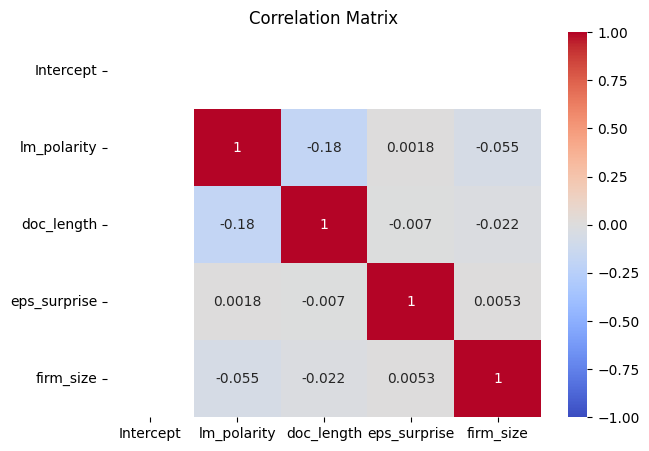

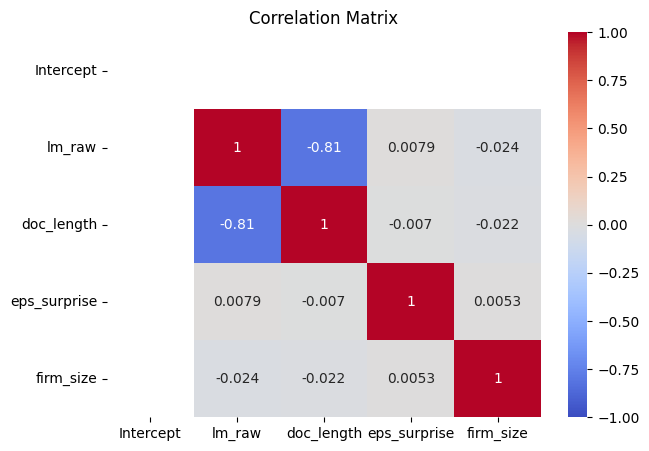

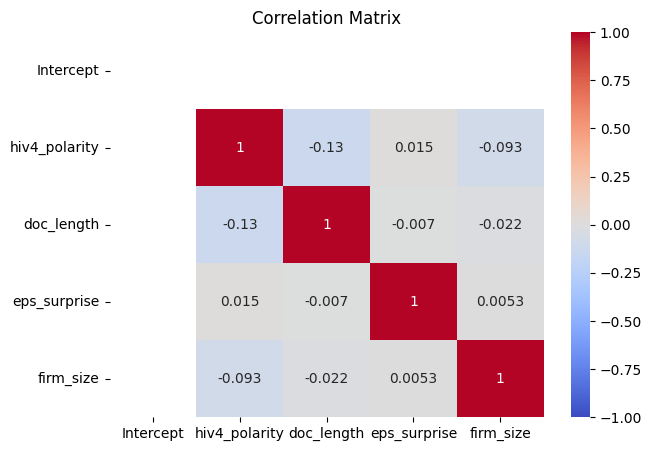

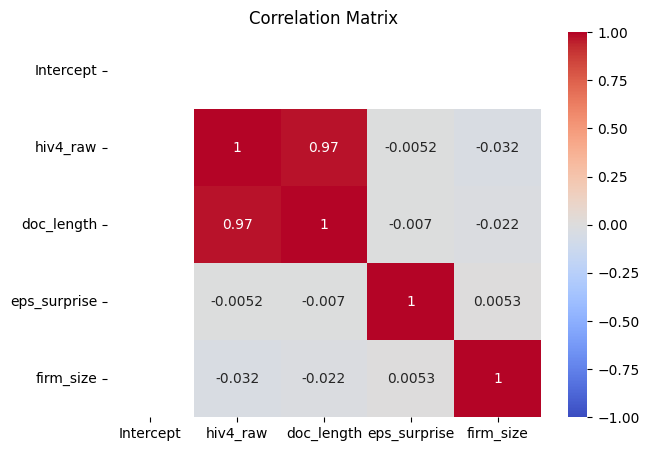

In [40]:
def colinearity_check(total_df):
    
    total_df.dropna(inplace=True)  

    for col in total_df.select_dtypes(include=['float64']).columns:
        total_df[col] = pd.to_numeric(total_df[col], errors='coerce')
    
    var_names = total_df.columns
    print(var_names)

    for x in range(0, 4):
    
        formula = f"{var_names[x]} + doc_length + eps_surprise + firm_size"
        
        X = patsy.dmatrix(formula, data=total_df, NA_action='drop', return_type='dataframe')
        corr_matrix = X.corr()
        plt.figure(figsize=(7, 5))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation Matrix')
        plt.show()
                
colinearity_check(total_df)

As we can see here row scores has very high correlation with doc lenght, which makes perfect sence, because since we do not adjust scores for frequency the score itself will depend on document length.

OLD RESULTS

This is the result of fitting regression on total data set. Almost in all cases only covariate variables has significant coeffisients. There are to exceptions: 
1. hiv4_polarity score for full_quarter_returns has coefficient -0.0751 with P>|t| 0.045.
    Negative sign suggests that this score moves in the opposit derection with full_quarter_returns (the opposit is expected).
    P_val is barely less 5% level (4.5%). Despite it's significants this is more likely to be a type one error.
2. hiv4_raw score for full_quarter_returns has coefficient -0.000020 with P>|t| 0.015.
    Slope has tiny ablosute value, so it is economicly insignificant, and would be regected at 1% significance level.

In [169]:
#OLD RESULTS
regression_single_slope(total_df_with_dummies, X_names, Y_names)

 X variable: lm_polarity 
 Y variable: 2_day_reterns 

Significant coefficients: 
             Variable      coef   std err       t  P>|t|    [0.025    0.975]
2         doc_length  0.000004  0.000001   3.318  0.001  0.000002  0.000007
3       eps_surprise  0.000087  0.000004  21.308  0.000  0.000078  0.000095
4                Q_1 -0.192300  0.063000  -3.048  0.002 -0.316000 -0.069000
5                Q_2 -0.206700  0.058000  -3.545  0.000 -0.321000 -0.092000
6                Q_3 -0.172400  0.058000  -2.998  0.003 -0.285000 -0.060000
17  sector_Utilities -0.219800  0.059000  -3.714  0.000 -0.336000 -0.104000 



 X variable: lm_polarity 
 Y variable: 3_day_reterns 

Significant coefficients: 
                   Variable      coef       std err       t  P>|t|    [0.025  \
2               doc_length  0.000003  9.920000e-07   3.201  0.001  0.000001   
3             eps_surprise  0.000077  2.960000e-06  25.853  0.000  0.000071   
4                      Q_1 -0.128400  4.900000e-02  -2.643  0

Fixed effects 

This func is converting date strings in quarter strings 

In [28]:
def convert_to_quarter(date_str):
    date = datetime.strptime(date_str, '%Y-%m-%d')
    quarter = (date.month - 1) // 3 + 1
    formatted_string = f'{date.year}.{quarter}'
    return float(formatted_string)

This function stackes all data in single dataframe 

In [29]:
def get_data_for_FE(dict_for_anal):

    total_df = pl.DataFrame()

    for company in dict_for_anal: 
        row_names = dict_for_anal[company].select(pl.col('row_names')).to_series().to_list()
        
        df = dict_for_anal[company].filter(pl.col("row_names") != 'doc_length')
        row_names.remove('doc_length')
        df = df.select(pl.exclude('row_names'))
    
        quarter_strings = [convert_to_quarter(date) for date in df.columns]
        quarter_strings = pl.Series('date', quarter_strings)
    
        df_w_dates = df.transpose().hstack([quarter_strings])
        df_w_company = df_w_dates.with_columns(pl.lit(company).alias('company'))

        column_name_order = ['company', 'date']
        column_name_order.extend(df.transpose().columns)

        prepared_df = df_w_company.select(column_name_order)
        total_df.vstack(prepared_df, in_place=True)

    total_df_pd = total_df.to_pandas()
   
    col_names =  ['company', 'date']
    col_names.extend(row_names)
   
    total_df_pd.columns = col_names
    total_df_pd = total_df_pd.set_index(['company', 'date'])
    
    return total_df_pd 

In [48]:
df_for_FE = get_data_for_FE(dict_for_anal)



Funck to show only significant params 

In [31]:
def extract_params_FE(summary, regressor_name):
    coef_table = summary.tables[1].as_html()
    
    coef_table_io = StringIO(coef_table)
    df = pd.read_html(coef_table_io, header=0, index_col=0)[0]
    
    df.columns = ['Parameter', 'std_err', 'T-stat', 'P-value', 'Lower CI', 'Upper CI']
    #significant_df = df[df['P-value'] < 0.05]

    return df.loc[regressor_name, ['Parameter', 'std_err', 'P-value', 'Lower CI', 'Upper CI']].copy()

This is func to fit FE

In [61]:
def fit_FE(df, formula):

    model = PanelOLS.from_formula(formula, data=df,)
    #result = model.fit(cov_type='clustered', cluster_entity=True)
    result = model.fit(cov_type='kernel')


    return result.summary

In [55]:
df_for_FE

lm_polarity  lm_raw  hiv4_polarity  hiv4_raw  eps_surprise  \
company date                                                                 
A       2019.1    -0.329588  -352.0       0.327818    1387.0        0.0402   
        2019.2    -0.321787  -353.0       0.318681    1421.0        0.1007   
        2019.3    -0.325390  -355.0       0.338225    1521.0        0.0681   
        2019.4    -0.266055  -493.0       0.400181    3540.0        0.0119   
        2020.1    -0.322245  -310.0       0.369223    1454.0        0.1379   
...                     ...     ...            ...       ...           ...   
ZTS     2022.4    -0.396226  -273.0       0.406832    1310.0        0.1233   
        2023.1    -0.291170  -709.0       0.439736    4535.0        0.1159   
        2023.2    -0.296748  -146.0       0.463665    1174.0        0.1081   
        2023.3    -0.285171  -150.0       0.453390    1284.0           NaN   
        2023.4    -0.267760  -147.0       0.448852    1290.0           NaN   

                   firm_size  day_2_returns  day_3_returns  day_4_returns  \
company date                                                                
A       2019.1  2.447506e+10      -0.332183      -0.007570      -0.124919   
        2019.2  2.068122e+10       0.228435       0.325175       0.097847   
        2019.3  2.119690e+10      -0.145456      -0.178184       0.415711   
        2019.4  2.514862e+10       0.347233       0.249660       0.131849   
        2020.1  2.463511e+10       0.487864      -0.072362      -0.961471   
...                      ...            ...            ...            ...   
ZTS     2022.4  6.164240e+10      -0.624454       0.094380      -0.186674   
        2023.1  7.942337e+10       0.199565       0.150378       0.175105   
        2023.2  7.688532e+10       4.782784       2.762701       2.303866   
        2023.3  8.321989e+10       2.275646       1.509204       1.327997   
        2023.4  7.094135e+10       3.694695       0.904831       1.496213   

                day_5_returns  day_6_returns  day_7_returns  \
company date                                                  
A       2019.1      -0.059365       0.009627      -0.074499   
        2019.2      -0.023135       0.126015      -0.065167   
        2019.3       0.473355       0.285712       0.508216   
        2019.4       0.068141       0.062336       0.079641   
        2020.1      -0.331233      -0.807334      -0.972837   
...                       ...            ...            ...   
ZTS     2022.4      -0.056747       0.110369       0.644938   
        2023.1       0.023997      -0.145746       0.000802   
        2023.2       1.880381       1.396425       1.172216   
        2023.3       0.853788       0.771473       0.594399   
        2023.4       1.439562       1.256715       0.766578   

                full_quarter_returns  
company date                          
A       2019.1             -0.251560  
        2019.2              0.008553  
        2019.3              0.117632  
        2019.4              0.015408  
        2020.1              0.155588  
...                              ...  
ZTS     2022.4              0.276128  
        2023.1             -0.033793  
        2023.2             -0.023322  
        2023.3             -0.154471  
        2023.4                   NaN  

[9830 rows x 13 columns]

This is func to iterate over all pairs of dep and indep var

In [62]:
def compute_all_FE(df_for_FE):

    var_names = df_for_FE.columns 
    #print(var_names)
    params_dict = {}
    all_params_dict = {}
    
    for x in range(0, 4):

        signif_params = []
        all_params = []

        for y in range(6, 13):
            data = df_for_FE.iloc[:, [x, 4, 5, y]].dropna().copy()

            formula = f"{var_names[y]} ~ {var_names[x]} + eps_surprise + firm_size + EntityEffects + TimeEffects"
            #print(formula)
            result = fit_FE(data, formula)
            #print(result)
            significant_df = extract_params_FE(result, var_names[x])
            
            #if not significant_df.empty:
            #    print(f' Dependent var: {var_names[y]} \n Independent var: {var_names[x]} \n Control vars: eps_surprise, firm_size\n')
            #    print(significant_df, '\n\n\n')
            
            #store all the params in dict
            if significant_df['P-value'] < 0.05:
                
                signif_params.append(significant_df)
            else:
                signif_params.append(0)
            
            all_params.append(significant_df)

        params_dict[var_names[x]] = signif_params
        all_params_dict[var_names[x]] = all_params
    
    return params_dict, all_params_dict    
  
params_dict, all_params_dict = compute_all_FE(df_for_FE)  

In [63]:
def plot_params(data):

    indices = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter' ]

    # Create figure and two subplots
    plt.figure(figsize=(8, 6))

    # First bar chart (lm_polarity and hiv4_polarity)
    plt.bar(indices, data['lm_polarity'], width=0.4, label='LM_dictionary')
    plt.bar(indices, data['hiv4_polarity'], width=0.4, label='HIV4_dictionary', color='tab:orange')
    plt.axhline(0, color='black', linewidth=1)
    plt.title('Polarity scores coefficients')
    plt.xlabel('Returns timeframe')
    plt.ylabel('Beta coefficients from fixed effects')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

In [ ]:
#all betas
plot_params(all_params_dict)

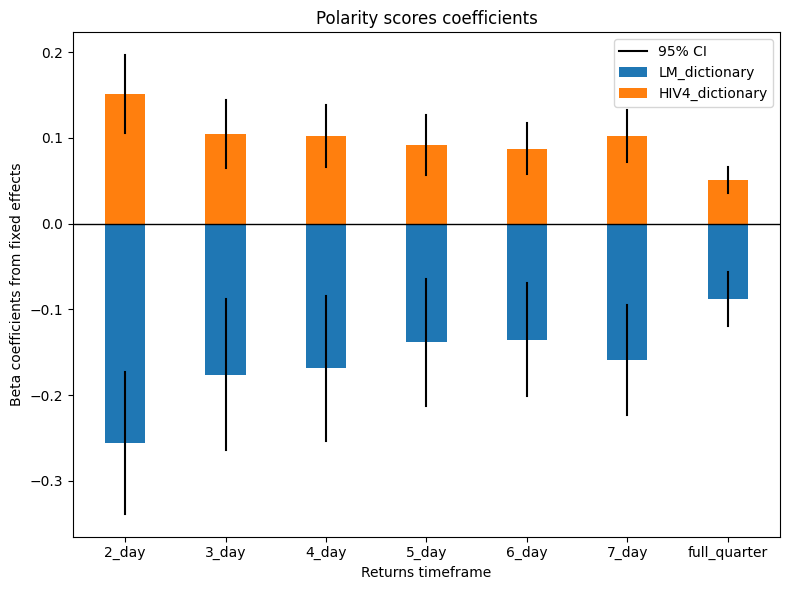

In [64]:
def plot_params(data):
    indices = ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter']
    x = np.arange(len(indices))  # Numeric positions for x-axis

    # Extract parameter values
    lm_params = [data['lm_polarity'][i]['Parameter'] for i in range(len(indices))]
    hiv4_params = [data['hiv4_polarity'][i]['Parameter'] for i in range(len(indices))]

    # Extract confidence intervals
    lm_lower = [data['lm_polarity'][i]['Lower CI'] for i in range(len(indices))]
    lm_upper = [data['lm_polarity'][i]['Upper CI'] for i in range(len(indices))]
    hiv4_lower = [data['hiv4_polarity'][i]['Lower CI'] for i in range(len(indices))]
    hiv4_upper = [data['hiv4_polarity'][i]['Upper CI'] for i in range(len(indices))]

    width = 0.4  # Bar width

    plt.figure(figsize=(8, 6))

    # Plot bars
    plt.bar(x, lm_params, width=width, label='LM_dictionary', color='tab:blue')
    plt.bar(x, hiv4_params, width=width, label='HIV4_dictionary', color='tab:orange')

    # Plot confidence intervals as vertical lines
    for i in range(len(indices)):
        plt.plot([x[i] , x[i] ], [lm_lower[i], lm_upper[i]], color='black', linewidth=1.5)
        plt.plot([x[i] , x[i] ], [hiv4_lower[i], hiv4_upper[i]], color='black', linewidth=1.5)

    plt.axhline(0, color='black', linewidth=1)  # Baseline
    plt.xticks(x, indices)  # Set x-axis labels
    plt.title('Polarity scores coefficients')
    plt.xlabel('Returns timeframe')
    plt.ylabel('Beta coefficients from fixed effects')

    # Custom legend entries
    ci_legend = mlines.Line2D([], [], color='black', linewidth=1.5, label='95% CI')
    
    # Combine both legends
    plt.legend(handles=[ci_legend] + plt.gca().get_legend_handles_labels()[0], loc='upper right')


    plt.tight_layout()
    plt.show()


plot_params(all_params_dict)

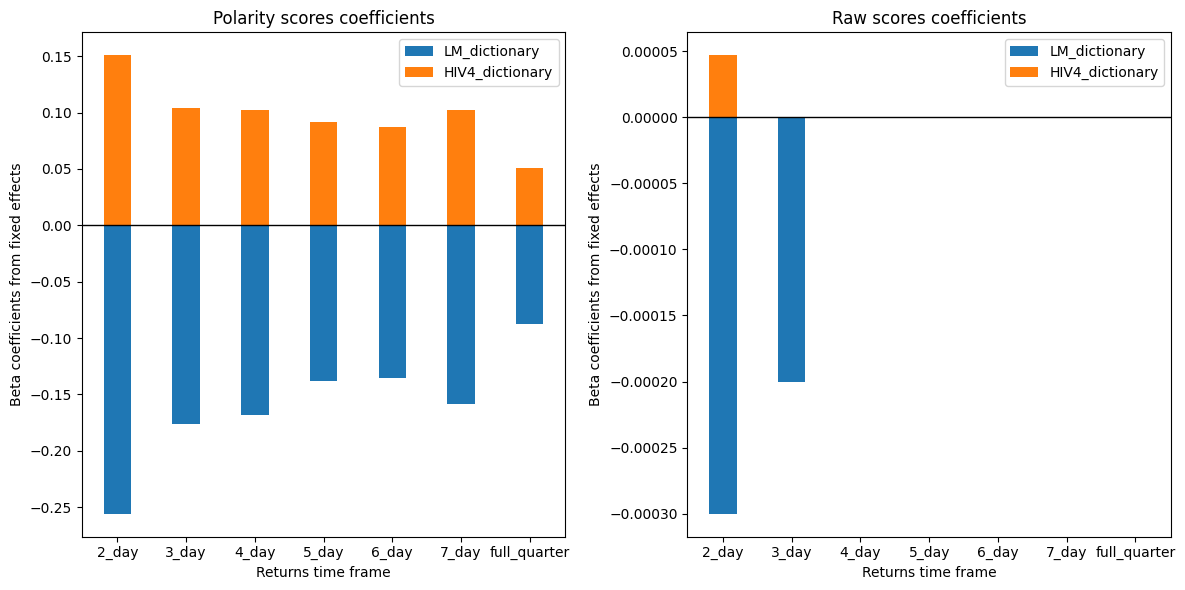

In [13]:
#only significant betas
plot_params(params_dict)

In [20]:
net_params = {'net_lm': [-0.1433, -0.0975, -0.0949, -0.0809, -0.0774, -0.091, -0.0453],
 'net_hv': [0.1248, 0.0868, 0.0841, 0.0743, 0.0711, 0.0837, 0.0422],
 'inter_lm': [-0.1557, -0.113, -0.1125, -0.0944, -0.0909, -0.1081, -0.0577],
 'inter_hv': [-0.1542, -0.1151, -0.1147, -0.0958, -0.0921, -0.1098, -0.0594]}


In [61]:
net_params = {
    'net_lm': [
        pd.Series({'Parameter': -0.1433, 'std_err': 0.0256, 'P-value': 0.0000, 'Lower CI': -0.1935, 'Upper CI': -0.0930}, name='net_lm'),
        pd.Series({'Parameter': -0.0975, 'std_err': 0.0239, 'P-value': 0.0000, 'Lower CI': -0.1444, 'Upper CI': -0.0506}, name='net_lm'),
        pd.Series({'Parameter': -0.0949, 'std_err': 0.0237, 'P-value': 0.0001, 'Lower CI': -0.1414, 'Upper CI': -0.0484}, name='net_lm'),
        pd.Series({'Parameter': -0.0809, 'std_err': 0.0208, 'P-value': 0.0001, 'Lower CI': -0.1216, 'Upper CI': -0.0402}, name='net_lm'),
        pd.Series({'Parameter': -0.0774, 'std_err': 0.0181, 'P-value': 0.0000, 'Lower CI': -0.1129, 'Upper CI': -0.0418}, name='net_lm'),
        pd.Series({'Parameter': -0.0910, 'std_err': 0.0182, 'P-value': 0.0000, 'Lower CI': -0.1267, 'Upper CI': -0.0553}, name='net_lm'),
        pd.Series({'Parameter': -0.0453, 'std_err': 0.0077, 'P-value': 0.0000, 'Lower CI': -0.0605, 'Upper CI': -0.0301}, name='net_lm')
    ],
    'net_hv': [
        pd.Series({'Parameter': 0.1248, 'std_err': 0.0191, 'P-value': 0.0000, 'Lower CI': 0.0874, 'Upper CI': 0.1623}, name='net_hv'),
        pd.Series({'Parameter': 0.0868, 'std_err': 0.0172, 'P-value': 0.0000, 'Lower CI': 0.0530, 'Upper CI': 0.1205}, name='net_hv'),
        pd.Series({'Parameter': 0.0841, 'std_err': 0.0163, 'P-value': 0.0000, 'Lower CI': 0.0522, 'Upper CI': 0.1160}, name='net_hv'),
        pd.Series({'Parameter': 0.0743, 'std_err': 0.0152, 'P-value': 0.0000, 'Lower CI': 0.0445, 'Upper CI': 0.1041}, name='net_hv'),
        pd.Series({'Parameter': 0.0711, 'std_err': 0.0132, 'P-value': 0.0000, 'Lower CI': 0.0453, 'Upper CI': 0.0969}, name='net_hv'),
        pd.Series({'Parameter': 0.0837, 'std_err': 0.0137, 'P-value': 0.0000, 'Lower CI': 0.0568, 'Upper CI': 0.1106}, name='net_hv'),
        pd.Series({'Parameter': 0.0422, 'std_err': 0.0065, 'P-value': 0.0000, 'Lower CI': 0.0295, 'Upper CI': 0.0548}, name='net_hv')
    ],
    'inter_lm': [
        pd.Series({'Parameter': -0.1557, 'std_err': 0.0309, 'P-value': 0.0000, 'Lower CI': -0.2163, 'Upper CI': -0.0951}, name='inter_lm'),
        pd.Series({'Parameter': -0.1130, 'std_err': 0.0294, 'P-value': 0.0001, 'Lower CI': -0.1706, 'Upper CI': -0.0553}, name='inter_lm'),
        pd.Series({'Parameter': -0.1125, 'std_err': 0.0274, 'P-value': 0.0000, 'Lower CI': -0.1662, 'Upper CI': -0.0589}, name='inter_lm'),
        pd.Series({'Parameter': -0.0944, 'std_err': 0.0222, 'P-value': 0.0000, 'Lower CI': -0.1380, 'Upper CI': -0.0508}, name='inter_lm'),
        pd.Series({'Parameter': -0.0909, 'std_err': 0.0188, 'P-value': 0.0000, 'Lower CI': -0.1277, 'Upper CI': -0.0542}, name='inter_lm'),
        pd.Series({'Parameter': -0.1081, 'std_err': 0.0186, 'P-value': 0.0000, 'Lower CI': -0.1444, 'Upper CI': -0.0717}, name='inter_lm'),
        pd.Series({'Parameter': -0.0577, 'std_err': 0.0103, 'P-value': 0.0000, 'Lower CI': -0.0779, 'Upper CI': -0.0374}, name='inter_lm')
    ],
    'inter_hv': [
        pd.Series({'Parameter': -0.1542, 'std_err': 0.0313, 'P-value': 0.0000, 'Lower CI': -0.2155, 'Upper CI': -0.0929}, name='inter_hv'),
        pd.Series({'Parameter': -0.1151, 'std_err': 0.0304, 'P-value': 0.0002, 'Lower CI': -0.1747, 'Upper CI': -0.0555}, name='inter_hv'),
        pd.Series({'Parameter': -0.1147, 'std_err': 0.0282, 'P-value': 0.0000, 'Lower CI': -0.1698, 'Upper CI': -0.0595}, name='inter_hv'),
        pd.Series({'Parameter': -0.0958, 'std_err': 0.0229, 'P-value': 0.0000, 'Lower CI': -0.1407, 'Upper CI': -0.0510}, name='inter_hv'),
        pd.Series({'Parameter': -0.0921, 'std_err': 0.0194, 'P-value': 0.0000, 'Lower CI': -0.1301, 'Upper CI': -0.0541}, name='inter_hv'),
        pd.Series({'Parameter': -0.1098, 'std_err': 0.0192, 'P-value': 0.0000, 'Lower CI': -0.1474, 'Upper CI': -0.0722}, name='inter_hv'),
        pd.Series({'Parameter': -0.0594, 'std_err': 0.0105, 'P-value': 0.0000, 'Lower CI': -0.0800, 'Upper CI': -0.0388}, name='inter_hv')
    ]
}

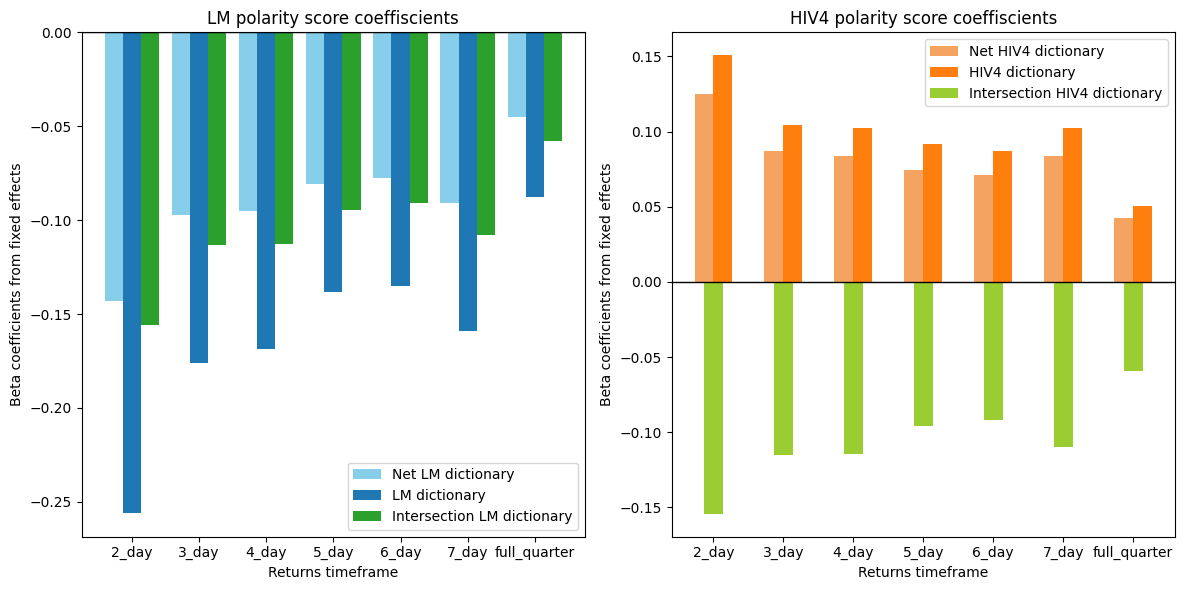

In [23]:
plt.figure(figsize=(12, 6))
indices = np.arange(len(net_params['net_lm']))  # Numeric indices for the x-axis
bar_width = 0.27 # Width of the bars

# Create figure and two subplots

# First bar chart (lm_polarity and hiv4_polarity)
plt.subplot(1, 2, 1)
plt.bar(indices - bar_width/1, net_params['net_lm'], width=bar_width, label='Net LM dictionary', color='skyblue')
plt.bar(indices, params_dict['lm_polarity'], width=bar_width, label='LM dictionary')
plt.bar(indices + bar_width/1, net_params['inter_lm'], width=bar_width, label='Intersection LM dictionary', color='tab:green')


plt.axhline(0, color='black', linewidth=1)  # Add horizontal line at y=0
plt.title('LM polarity score coeffiscients')
plt.xlabel('Returns timeframe')
plt.ylabel('Beta coefficients from fixed effects')
plt.xticks(indices, ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter'])
plt.legend()



# Scond bar chart (lm_raw and hiv4_raw)
plt.subplot(1, 2, 2)
plt.bar(indices - bar_width/2, net_params['net_hv'], width=bar_width, label='Net HIV4 dictionary', color='sandybrown')
plt.bar(indices + bar_width/2, params_dict['hiv4_polarity'], width=bar_width, label='HIV4 dictionary', color='tab:orange')
plt.bar(indices, net_params['inter_hv'], width=bar_width, label='Intersection HIV4 dictionary', color='yellowgreen')

plt.axhline(0, color='black', linewidth=1)
plt.title('HIV4 polarity score coeffiscients')
plt.xlabel('Returns timeframe')
plt.ylabel('Beta coefficients from fixed effects')
plt.xticks(indices, ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter'])
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [43]:
all_params_dict.keys()

dict_keys(['lm_polarity', 'hiv4_polarity', 'lm_net', 'hv_net', 'lm_inter', 'hv_inter'])

In [ ]:
def plot_all_params(net_params, params_dict):
    plt.figure(figsize=(12, 6))
    indices = np.arange(len(net_params['net_lm']))  # Numeric indices for x-axis
    bar_width = 0.27  # Width of bars

    # Extract parameter values
    net_lm_params = [net_params['net_lm'][i]['Parameter'] for i in range(len(indices))]
    inter_lm_params = [net_params['inter_lm'][i]['Parameter'] for i in range(len(indices))]
    lm_params = [params_dict['lm_polarity'][i]['Parameter'] for i in range(len(indices))]

    net_hv_params = [net_params['net_hv'][i]['Parameter'] for i in range(len(indices))]
    inter_hv_params = [net_params['inter_hv'][i]['Parameter'] for i in range(len(indices))]
    hiv4_params = [params_dict['hiv4_polarity'][i]['Parameter'] for i in range(len(indices))]

    # Extract confidence intervals
    net_lm_lower = [net_params['net_lm'][i]['Lower CI'] for i in range(len(indices))]
    net_lm_upper = [net_params['net_lm'][i]['Upper CI'] for i in range(len(indices))]
    inter_lm_lower = [net_params['inter_lm'][i]['Lower CI'] for i in range(len(indices))]
    inter_lm_upper = [net_params['inter_lm'][i]['Upper CI'] for i in range(len(indices))]
    lm_lower = [params_dict['lm_polarity'][i]['Lower CI'] for i in range(len(indices))]
    lm_upper = [params_dict['lm_polarity'][i]['Upper CI'] for i in range(len(indices))]

    net_hv_lower = [net_params['net_hv'][i]['Lower CI'] for i in range(len(indices))]
    net_hv_upper = [net_params['net_hv'][i]['Upper CI'] for i in range(len(indices))]
    inter_hv_lower = [net_params['inter_hv'][i]['Lower CI'] for i in range(len(indices))]
    inter_hv_upper = [net_params['inter_hv'][i]['Upper CI'] for i in range(len(indices))]
    hiv4_lower = [params_dict['hiv4_polarity'][i]['Lower CI'] for i in range(len(indices))]
    hiv4_upper = [params_dict['hiv4_polarity'][i]['Upper CI'] for i in range(len(indices))]

    # Custom CI legend
    ci_legend = mlines.Line2D([], [], color='black', linewidth=1.5, label='95% CI')

    # First subplot (LM polarity scores)
    plt.subplot(1, 2, 1)
    plt.bar(indices - bar_width, net_lm_params, width=bar_width, label='Net LM dictionary', color='skyblue')
    plt.bar(indices, lm_params, width=bar_width, label='LM dictionary', color='tab:blue')
    plt.bar(indices + bar_width, inter_lm_params, width=bar_width, label='Intersection LM dictionary', color='tab:green')

    # Plot confidence intervals
    for i in range(len(indices)):
        plt.plot([indices[i] - bar_width, indices[i] - bar_width], [net_lm_lower[i], net_lm_upper[i]], color='black', linewidth=1.5)
        plt.plot([indices[i], indices[i]], [lm_lower[i], lm_upper[i]], color='black', linewidth=1.5)
        plt.plot([indices[i] + bar_width, indices[i] + bar_width], [inter_lm_lower[i], inter_lm_upper[i]], color='black', linewidth=1.5)

    plt.axhline(0, color='black', linewidth=1)  # Baseline
    plt.title('LM Polarity Score Coefficients')
    plt.xlabel('Returns timeframe')
    plt.ylabel('Beta coefficients from fixed effects')
    plt.xticks(indices, ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter'])

    # Add legends for bars + CI in the first subplot
    plt.legend(handles=[ci_legend] + plt.gca().get_legend_handles_labels()[0], loc='best')

    # Second subplot (HIV4 polarity scores)
    plt.subplot(1, 2, 2)
    plt.bar(indices - bar_width, net_hv_params, width=bar_width, label='Net HIV4 dictionary', color='sandybrown')
    plt.bar(indices, hiv4_params, width=bar_width, label='HIV4 dictionary', color='tab:orange')
    plt.bar(indices + bar_width, inter_hv_params, width=bar_width, label='Intersection HIV4 dictionary', color='yellowgreen')

    # Plot confidence intervals
    for i in range(len(indices)):
        plt.plot([indices[i] - bar_width, indices[i] - bar_width], [net_hv_lower[i], net_hv_upper[i]], color='black', linewidth=1.5)
        plt.plot([indices[i], indices[i]], [hiv4_lower[i], hiv4_upper[i]], color='black', linewidth=1.5)
        plt.plot([indices[i] + bar_width, indices[i] + bar_width], [inter_hv_lower[i], inter_hv_upper[i]], color='black', linewidth=1.5)

    plt.axhline(0, color='black', linewidth=1)
    plt.title('HIV4 Polarity Score Coefficients')
    plt.xlabel('Returns timeframe')
    plt.ylabel('Beta coefficients from fixed effects')
    plt.xticks(indices, ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter'])

    # Add legends for bars + CI in the second subplot
    plt.legend(handles=[ci_legend] + plt.gca().get_legend_handles_labels()[0], loc='best')

    # Display the plots
    plt.tight_layout()
    plt.show()

plot_all_params(all_params_dict, all_params_dict)

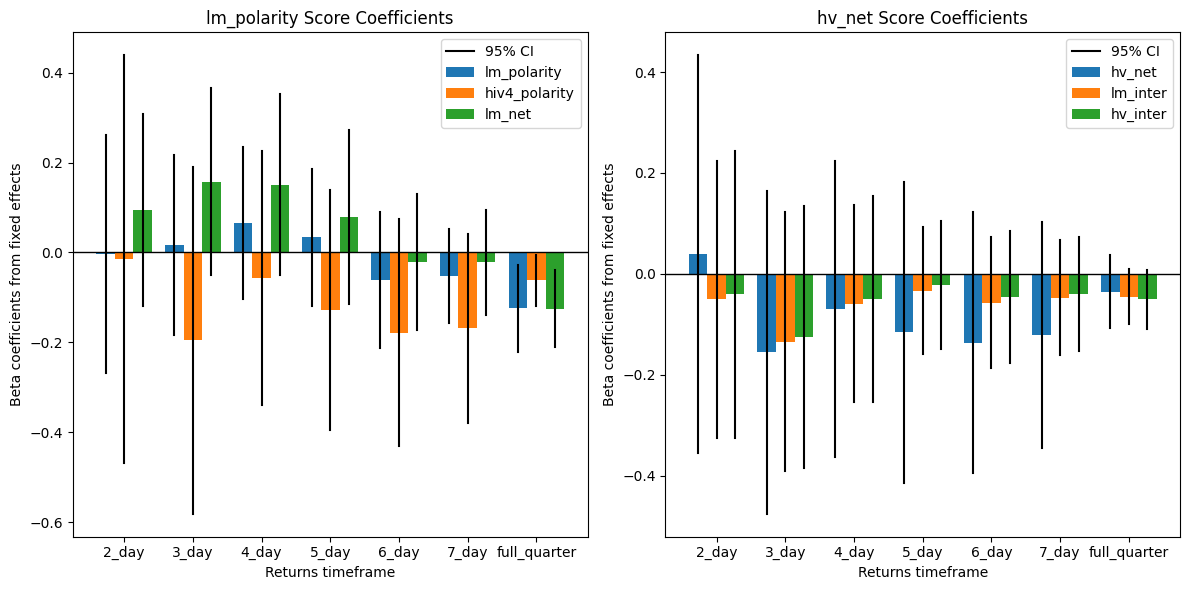

In [45]:
def plot_all_params_dynamic(net_params, params_dict):
    plt.figure(figsize=(12, 6))
    
    indices = np.arange(len(net_params[list(net_params.keys())[0]]))  # Numeric indices for x-axis
    bar_width = 0.27  # Width of bars
    
    param_keys = list(net_params.keys())
    dict_keys = list(params_dict.keys())
    
    param_values = {key: [net_params[key][i]['Parameter'] for i in range(len(indices))] for key in param_keys}
    dict_values = {key: [params_dict[key][i]['Parameter'] for i in range(len(indices))] for key in dict_keys}
    
    # Extract confidence intervals
    param_lower = {key: [net_params[key][i]['Lower CI'] for i in range(len(indices))] for key in param_keys}
    param_upper = {key: [net_params[key][i]['Upper CI'] for i in range(len(indices))] for key in param_keys}
    dict_lower = {key: [params_dict[key][i]['Lower CI'] for i in range(len(indices))] for key in dict_keys}
    dict_upper = {key: [params_dict[key][i]['Upper CI'] for i in range(len(indices))] for key in dict_keys}
    
    ci_legend = mlines.Line2D([], [], color='black', linewidth=1.5, label='95% CI')
    
    # First subplot
    plt.subplot(1, 2, 1)
    for i, key in enumerate(param_keys[:3]):  # First three keys for the first plot
        plt.bar(indices + (i - 1) * bar_width, param_values[key], width=bar_width, label=key)
    
    for i in range(len(indices)):
        for j, key in enumerate(param_keys[:3]):
            plt.plot([indices[i] + (j - 1) * bar_width, indices[i] + (j - 1) * bar_width], [param_lower[key][i], param_upper[key][i]], color='black', linewidth=1.5)
    
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'{param_keys[0]} Score Coefficients')
    plt.xlabel('Returns timeframe')
    plt.ylabel('Beta coefficients from fixed effects')
    plt.xticks(indices, ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter'])
    plt.legend(handles=[ci_legend] + plt.gca().get_legend_handles_labels()[0], loc='best')
    
    # Second subplot
    plt.subplot(1, 2, 2)
    for i, key in enumerate(param_keys[3:]):  # Remaining keys for the second plot
        plt.bar(indices + (i - 1) * bar_width, param_values[key], width=bar_width, label=key)
    
    for i in range(len(indices)):
        for j, key in enumerate(param_keys[3:]):
            plt.plot([indices[i] + (j - 1) * bar_width, indices[i] + (j - 1) * bar_width], [param_lower[key][i], param_upper[key][i]], color='black', linewidth=1.5)
    
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'{param_keys[3]} Score Coefficients')
    plt.xlabel('Returns timeframe')
    plt.ylabel('Beta coefficients from fixed effects')
    plt.xticks(indices, ['2_day', '3_day', '4_day', '5_day', '6_day', '7_day', 'full_quarter'])
    plt.legend(handles=[ci_legend] + plt.gca().get_legend_handles_labels()[0], loc='best')
    
    plt.tight_layout()
    plt.show()

plot_all_params_dynamic(all_params_dict, all_params_dict)

jupyter nbconvert --to html Parsim-sec\src\Analysis\excess_ret_500.ipynb